<a href="https://colab.research.google.com/github/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000_analyze_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT on 2000-2000 prediction benchmark trial**

To compare bert with other model, evaluate on our benchmark setting.

Basic code is from here: 
https://github.com/karino2/US-patent-analysis/blob/master/notebook/tfidf_nearest.ipynb

Computing whole 1000x2525 pair of patent seems too time consuming that I create separate notebook for predict only.
https://github.com/karino2/US-patent-analysis/blob/bert_input/colab/bert_benchmark_2000_save_result.ipynb

This notebook only analyze the result.

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!mkdir -p ./bert/data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [6]:
!gsutil cp gs://karino2-uspatent/citations_info_2000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/testset_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/training_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/grants_for_2000.df.gz ./bert/data/

Copying gs://karino2-uspatent/citations_info_2000.df.gz...
/ [1 files][234.3 KiB/234.3 KiB]                                                
Operation completed over 1 objects/234.3 KiB.                                    
Copying gs://karino2-uspatent/testset_app_1000.df.gz...
/ [1 files][ 13.4 MiB/ 13.4 MiB]                                                
Operation completed over 1 objects/13.4 MiB.                                     
Copying gs://karino2-uspatent/training_app_1000.df.gz...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     
Copying gs://karino2-uspatent/grants_for_2000.df.gz...
- [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
citations_info_target = pd.read_pickle("./bert/data/citations_info_2000.df.gz")
# training_app_df = pd.read_pickle("./bert/data/training_app_1000.df.gz")
testset_app_df = pd.read_pickle("./bert/data/testset_app_1000.df.gz")
grants_target_df = pd.read_pickle("./bert/data/grants_for_2000.df.gz")

# Evaluation of one block

Result is stored on 20x2524 block each.
First, write evaluation code for 1 block, then integrate.


In [8]:
WHOLE_APP_NUM=1000
WHOLE_GRANTS_NUM = grants_target_df.shape[0]

WHOLE_PAIR_NUM = WHOLE_APP_NUM*WHOLE_GRANTS_NUM
WHOLE_PAIR_NUM, WHOLE_GRANTS_NUM

(2524000, 2524)

In [9]:
BLOCK_SIZE = 20*WHOLE_GRANTS_NUM
TOTAL_BLOCK_NUM = WHOLE_PAIR_NUM//BLOCK_SIZE
APPS_PER_BLOCK = WHOLE_APP_NUM//TOTAL_BLOCK_NUM

BLOCK_SIZE, TOTAL_BLOCK_NUM, APPS_PER_BLOCK

(50480, 50, 20)

In [0]:
def cited_ranking(app_ridx, block_id, result_block):
  app_idx = app_ridx + APPS_PER_BLOCK*block_id
  
  assert app_ridx < APPS_PER_BLOCK and app_ridx >= 0
  
  # print("idx:{}, ridx:{}".format(app_idx, app_ridx))

  result_for_one_app = result_block[app_ridx*WHOLE_GRANTS_NUM: (app_ridx+1)*WHOLE_GRANTS_NUM]
  result_for_one_app_true = [tup[1] for tup in result_for_one_app]
  one_app_id = testset_app_df.app_id[app_idx]
  cited_ids = citations_info_target[citations_info_target.app_id == one_app_id].parsed
  
  def gen_fun():

    for cited_id in cited_ids.values:
      i, = np.where(grants_target_df.parsed.values == cited_id)
      cited_index = i[0]
      ranking = sorted(result_for_one_app_true, reverse=True).index(result_for_one_app_true[cited_index])
      yield (one_app_id, cited_ids.values[0], ranking, result_for_one_app_true[cited_index])
  return list(gen_fun())

In [0]:
def result_block_filename(block_id):
  pair_begin = (block_id)*BLOCK_SIZE
  pair_end = (block_id+1)*BLOCK_SIZE
  
  return "result_{}_{}.pkl.gz".format(pair_begin, pair_end)

def download_result(block_id):
  filename = result_block_filename(block_id)
  !gsutil cp gs://karino2-uspatent/features/{filename} ./bert/data/{filename}
    
def load_result(block_id):
  filename = result_block_filename(block_id)
  # print("result flename: {}".format(filename))
  with gzip.open("./bert/data/{}".format(filename), 'rb') as f:
    return pickle.load(f)

In [0]:
def load_and_calc_rank_tuples(block_id):
  result_block = load_result(block_id)
  return [tup for apprid in range(APPS_PER_BLOCK) for tup in cited_ranking(apprid, block_id, result_block)]

# Integrate whole results

In [14]:
!gsutil -m cp gs://karino2-uspatent/features/result* ./bert/data/

Copying gs://karino2-uspatent/features/result_0_50480.pkl.gz...
Copying gs://karino2-uspatent/features/result_1009600_1060080.pkl.gz...
Copying gs://karino2-uspatent/features/result_1110560_1161040.pkl.gz...
Copying gs://karino2-uspatent/features/result_100960_151440.pkl.gz...
Copying gs://karino2-uspatent/features/result_1161040_1211520.pkl.gz...
Copying gs://karino2-uspatent/features/result_1211520_1262000.pkl.gz...
Copying gs://karino2-uspatent/features/result_1362960_1413440.pkl.gz...
Copying gs://karino2-uspatent/features/result_1262000_1312480.pkl.gz...
Copying gs://karino2-uspatent/features/result_1312480_1362960.pkl.gz...
Copying gs://karino2-uspatent/features/result_1060080_1110560.pkl.gz...
Copying gs://karino2-uspatent/features/result_1413440_1463920.pkl.gz...
Copying gs://karino2-uspatent/features/result_1463920_1514400.pkl.gz...
Copying gs://karino2-uspatent/features/result_1514400_1564880.pkl.gz...
Copying gs://karino2-uspatent/features/result_151440_201920.pkl.gz...
Copy

In [0]:
whole_tups = [tup for block_id in range(50) for tup in load_and_calc_rank_tuples(block_id)]

In [18]:
len(whole_tups)

2059

In [0]:
whole_ranks = [tup[2] for tup in whole_tups]

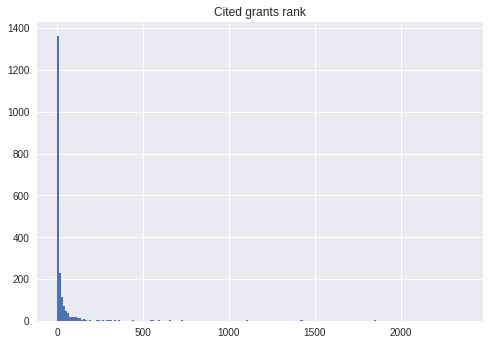

In [22]:
plt.hist(whole_ranks, bins=200)
plt.title("Cited grants rank")
plt.show()

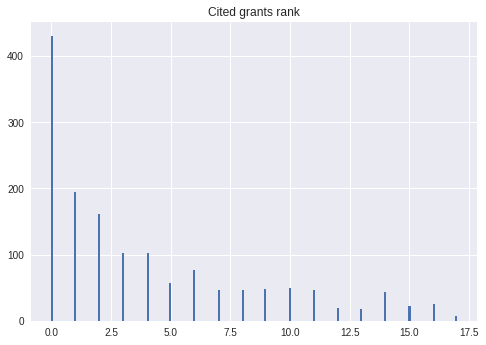

In [23]:
plt.hist(sorted(whole_ranks)[0:1500], bins=200)
plt.title("Cited grants rank")
plt.show()

In [32]:
sum(np.array(whole_ranks) < 10)

1265

In [27]:
sum(np.array(whole_ranks) <= 20)

1548

Draw rank-cover curve

In [0]:
whole_ranks_arr = np.array(whole_ranks)

In [35]:
whole_ranks_arr.max()

2362

In [0]:
positive_counts = [sum(whole_ranks_arr <= thrd) for thrd in range(WHOLE_GRANTS_NUM)]

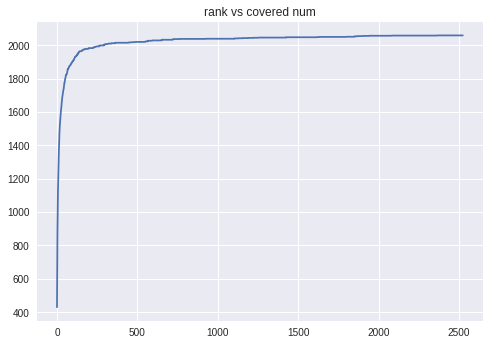

In [39]:
plt.plot(range(WHOLE_GRANTS_NUM), positive_counts)
plt.title("rank vs covered num")
plt.show()

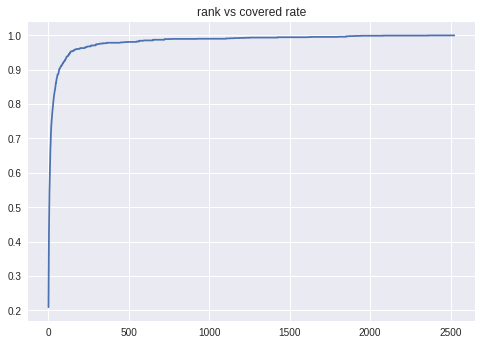

In [42]:
plt.plot(range(WHOLE_GRANTS_NUM), np.array(positive_counts)/len(whole_tups))
plt.title("rank vs covered rate")
plt.show()

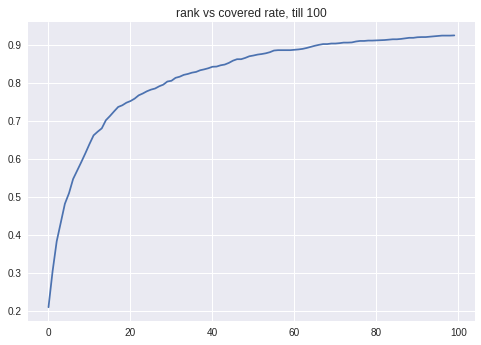

In [43]:
plt.plot(range(100), (np.array(positive_counts)/len(whole_tups))[0:100])
plt.title("rank vs covered rate, till 100")
plt.show()

# Try and error

In [0]:
filename = result_block_filename(0)
filename

'result_0_50480.pkl.gz'

In [0]:
cited_ranking(2, 1, result_block)

idx:22, ridx:2


[(13004544, 6845583, 0, 0.9999095)]

In [0]:
testset_app_df.app_id[22]

13004544

In [0]:
pd.DataFrame({"rank": sorted(block_ranks)})

,rank
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [0]:
result_block = load_result(1)

In [0]:
block_rank_tuples = [tup for apprid in range(APPS_PER_BLOCK) for tup in cited_ranking(apprid, 1, result_block)]

In [0]:
block_ranks = [tup[2] for tup in block_rank_tuples]

In [0]:
block_ranks[0:5]

[81, 0, 0, 0, 0]

In [0]:
sorted(block_ranks)[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

In [0]:
len(block_rank_tuples)

54

In [0]:
import matplotlib.pyplot as plt

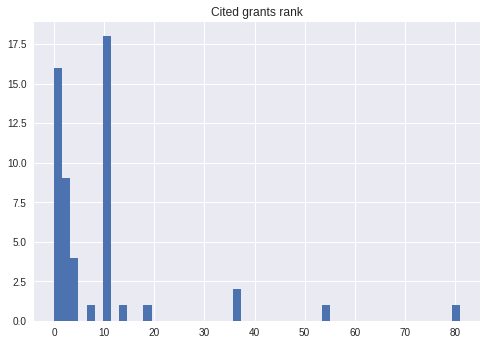

In [0]:
plt.hist(block_ranks, bins=50)
plt.title("Cited grants rank")
plt.show()

### Result evaluation

First, check the ranking of scores for label patent.

In [0]:
!gsutil cp gs://karino2-uspatent/features/result_0_50480.pkl.gz ./

Copying gs://karino2-uspatent/features/result_0_50480.pkl.gz...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [0]:
!gsutil cp gs://karino2-uspatent/citations_info_2000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/testset_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/training_app_1000.df.gz ./bert/data/
!gsutil cp gs://karino2-uspatent/grants_for_2000.df.gz ./bert/data/

Copying gs://karino2-uspatent/citations_info_2000.df.gz...
/ [1 files][234.3 KiB/234.3 KiB]                                                
Operation completed over 1 objects/234.3 KiB.                                    
Copying gs://karino2-uspatent/testset_app_1000.df.gz...
/ [1 files][ 13.4 MiB/ 13.4 MiB]                                                
Operation completed over 1 objects/13.4 MiB.                                     
Copying gs://karino2-uspatent/training_app_1000.df.gz...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     
Copying gs://karino2-uspatent/grants_for_2000.df.gz...
- [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
import gzip
import pickle
with gzip.open("result_0_50480.pkl.gz", 'rb') as f:
     result_unwrap = pickle.load(f)

# Try and error

Below here is try and error.

In [0]:
app_idx = 0


result_for_one_app = result_unwrap[app_idx*GRANTS_NUM: (app_idx+1)*GRANTS_NUM]

In [0]:
one_app_id = app_ids[app_idx]

In [0]:
one_app_id

14307191

In [0]:
cited_ids = citations_info_target[citations_info_target.app_id == one_app_id].parsed

In [0]:
cited_ids.values[0]

7576688

In [0]:
result_for_one_app[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

In [0]:
result_for_one_app_true = [tup[1] for tup in result_for_one_app]

In [0]:
grants_target_df.shape

(2524, 2)

In [0]:
i, = np.where(grants_target_df.parsed.values == cited_ids.values[0])
cited_index = i[0]

In [0]:
grants_target_df.parsed.values[cited_index]

7576688

In [0]:
result_for_one_app_true[cited_index:cited_index+3]

[0.00013937514, 0.47318903, 0.00014103286]

In [0]:
grants_target_df.parsed.values[0]

6837383

In [0]:
grants_target_df.parsed.values[0:5]

array([6837383, 6837647, 6837799, 6837893, 6837910])

In [0]:
np.where(grants_target_df.parsed.values == 6837647)

(array([1]),)

In [0]:
sorted(result_for_one_app_true, reverse=True).index(result_for_one_app_true[cited_index])

1189

In [0]:
cited_ranking(0)

[(14307191, 7576688, 1189, 0.00013937514)]

In [0]:
cited_ranking(1)

[(13137006, 6856341, 36, 0.9998958)]

In [0]:
result_unwrap[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

In [0]:
result_unwrap[0:5]

[array([9.9987113e-01, 1.2879973e-04], dtype=float32),
 array([9.9987471e-01, 1.2525565e-04], dtype=float32),
 array([9.9986601e-01, 1.3391985e-04], dtype=float32),
 array([9.9987304e-01, 1.2690226e-04], dtype=float32),
 array([9.9986780e-01, 1.3221534e-04], dtype=float32)]

Check first app result manually

In [0]:
label_df.head()

,6837383,6837647,6837799,6837893,6837910,6838140,6838207,6838507,6838812,6838925,...,8334161,8334431,8334887,8336128,8336158,8336789,8336964,8337193,8339697,8340894
14307191,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13137006,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12741959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12643447,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14200253,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [0]:
citations_info_target[citations_info_target["app_id"]==14307191].parsed

698    7576688
Name: parsed, dtype: int64

In [0]:
label_df.columns.get_loc(7576688)

1533

In [0]:
result_unwrap[1530:1535]

[array([9.9984968e-01, 1.5024767e-04], dtype=float32),
 array([9.9986899e-01, 1.3095887e-04], dtype=float32),
 array([9.9981815e-01, 1.8189823e-04], dtype=float32),
 array([9.9986064e-01, 1.3937514e-04], dtype=float32),
 array([0.52681094, 0.47318903], dtype=float32)]

In [0]:
label_df.columns[1533]

7576688

In [0]:
result_unwrap[1530:1535]

[array([9.9984968e-01, 1.5024767e-04], dtype=float32),
 array([9.9986899e-01, 1.3095887e-04], dtype=float32),
 array([9.9981815e-01, 1.8189823e-04], dtype=float32),
 array([9.9986064e-01, 1.3937514e-04], dtype=float32),
 array([0.52681094, 0.47318903], dtype=float32)]

In [0]:
[one["index"] for one in tupples[1530:1535]]

['0_7575179', '0_7575572', '0_7575840', '0_7576688', '0_7577750']

In [0]:
tupples[0]

{'claim_app': '\n \n  1 . A method to aggregate, filter, and share energy data for analysis, the method comprising:\n receiving first data associated with a first electrical circuit, the first data having a first protocol; \n sampling the first data at a first sampling rate to generate first digital data, wherein the first sampling rate is substantially continuous; and \n transmitting reporting digital data over a network having a network protocol different from the first protocol, the reporting digital data comprising at least the first digital data, wherein the reporting digital data is transmitted at a reporting rate that is decoupled from the first sampling rate. \n \n \n \n  2 . The method of  claim 1  further comprising:\n receiving second data associated with a second electrical circuit, the second data having a second protocol different from the first protocol; and \n sampling the second data at a second sampling rate to generate second digital data, wherein the second sampling

In [0]:
label_df.columns[0]

6837383

In [0]:
len(label_df.columns)

2524

In [0]:
first_res = [tup[1] for tup in result_unwrap[0:2524]]

In [0]:
first_res.index(max(first_res))

2429

In [0]:
result_unwrap[2429]

array([9.6167554e-05, 9.9990380e-01], dtype=float32)

In [0]:
sorted(first_res, reverse=True)[0:100]

[0.9999038,
 0.9999002,
 0.9999,
 0.9998981,
 0.9998971,
 0.99989426,
 0.9998926,
 0.9998896,
 0.9998851,
 0.9998845,
 0.9998822,
 0.9998683,
 0.99986625,
 0.99986136,
 0.9998572,
 0.999851,
 0.99984765,
 0.99984276,
 0.99983644,
 0.9998337,
 0.9998331,
 0.99982184,
 0.9998141,
 0.9998128,
 0.99981123,
 0.99979824,
 0.9997905,
 0.99977726,
 0.9997663,
 0.9997607,
 0.99974984,
 0.9997284,
 0.99970305,
 0.99966955,
 0.99966323,
 0.99964607,
 0.99948835,
 0.9994863,
 0.9994686,
 0.9994173,
 0.9993445,
 0.99932206,
 0.9992962,
 0.99916995,
 0.99912757,
 0.99909306,
 0.9990852,
 0.9990293,
 0.9989574,
 0.9989573,
 0.99878114,
 0.9985979,
 0.99844414,
 0.9983937,
 0.9983798,
 0.99776447,
 0.99763006,
 0.99744403,
 0.99735945,
 0.9972683,
 0.99682057,
 0.99669987,
 0.9965874,
 0.9965056,
 0.9963832,
 0.9958139,
 0.9955245,
 0.9948787,
 0.9948294,
 0.9942055,
 0.9940918,
 0.99350864,
 0.9931433,
 0.99291205,
 0.9925493,
 0.9902334,
 0.987956,
 0.98655933,
 0.9856634,
 0.9856187,
 0.9761249,
 0

First application is not so impressive result. Try second one.

In [0]:
one_res = [tup[1] for tup in result_unwrap[2524*1:2524*2]]

In [0]:
citations_info_target[citations_info_target["app_id"]==13137006].parsed

1150    6856341
Name: parsed, dtype: int64

In [0]:
label_df.columns.get_loc(6856341)

43

In [0]:
one_res[43]

0.9998958

In [0]:
one_res.index(max(one_res))

1862

In [0]:
one_res[1862]

0.99990904

In [0]:
sorted(one_res, reverse=True)[0:50]

[0.99990904,
 0.99990845,
 0.9999075,
 0.9999074,
 0.999907,
 0.99990594,
 0.9999052,
 0.999905,
 0.99990475,
 0.9999039,
 0.9999038,
 0.9999032,
 0.9999031,
 0.9999031,
 0.99990296,
 0.9999027,
 0.9999021,
 0.99990153,
 0.9999014,
 0.9999012,
 0.99990106,
 0.99990094,
 0.99990046,
 0.99990034,
 0.9999,
 0.99989974,
 0.99989927,
 0.999899,
 0.9998988,
 0.9998987,
 0.9998982,
 0.99989796,
 0.9998976,
 0.99989736,
 0.9998964,
 0.99989605,
 0.9998958,
 0.999895,
 0.99989486,
 0.9998944,
 0.99989426,
 0.9998933,
 0.9998933,
 0.99989307,
 0.9998926,
 0.9998921,
 0.9998909,
 0.99988914,
 0.9998889,
 0.9998882]

In [0]:
sorted(one_res, reverse=True).index(one_res[43])

36

In [0]:
label_df.columns[43]

6856341

In [0]:
len(one_res)

2524

In [0]:
list(test_fdict.keys())

['input_ids', 'input_mask', 'segment_ids', 'label_ids']

In [0]:
testset_app_df.head()

,app_id,xml
0,14307191,"<us-patent-application lang=""EN"" dtd-version=""..."
1,13137006,"<us-patent-application lang=""EN"" dtd-version=""..."
2,12741959,"<us-patent-application lang=""EN"" dtd-version=""..."
3,12643447,"<us-patent-application lang=""EN"" dtd-version=""..."
4,14200253,"<us-patent-application lang=""EN"" dtd-version=""..."


In [0]:
test_data.head()

,index,claim_app,claim_cited_grant,label
0,0,1 . A rotational angle detection device for a ...,1. A tangible computer-readable medium having ...,not_entailment
1,1,1 . A method comprising:sensing electrocardiog...,"1. A medical system, comprising:an implantable...",entailment
2,2,1 . A system for controlling temperature insid...,1. An integrated differential receiver for an ...,not_entailment
3,3,1 . A recording apparatus for recording update...,1. A method for indicating a priority of a Voi...,not_entailment
4,4,1 . Apparatus for moving a material within an ...,1. A wellbore packer having an expandable pack...,entailment


In [0]:
1000*1000*(43.7/2502)/(60*60)

4.85167421618261

### Below here is obsolete, update to merge to above

# Dataset setup

Download dataframe from cloud storage

### Utility: Retrieve just claim. Remove all tags.

In [0]:
import re

In [0]:
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")

In [0]:
def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
  
  
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

### Create label data

In [0]:
def set_one_answer_appid(labeldf, oneappid):
    cited_patids = citations_info_target[citations_info_target.app_id == oneappid].parsed
    labeldf.loc[oneappid] = labeldf.columns.isin(cited_patids)
    
    
def create_label_df():
    label_df = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    for appid in testset_app_df.app_id:
        set_one_answer_appid(label_df, appid)
    return label_df

In [0]:
label_df = create_label_df()
label_df.shape

(1000, 2524)

Confirm label data

In [0]:
label_df.loc[14307191].idxmax()

7576688

In [0]:
citations_info_target[citations_info_target["app_id"]==14307191].parsed

698    7576688
Name: parsed, dtype: int64

# Test set evaluation code

For predcition, we need to preprocess input and it takes some times.
So I split original code to preprocess function and evaluation function

In [0]:
def test_set_preprocess(preprocess_func):
  predictdf = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
   preprocess_func(testset_app_df["xml"].map(whole_xml_to_claim))

In [0]:
testset_app_claims = testset_app_df["xml"].map(whole_xml_to_claim)

In [0]:
testset_app_claims.shape

(1000,)

In [0]:
def predict_test_set(predict_func):
    """
    predict_func(claims) return NxM of boolean. N is len(claims). M is rownum of grants_target_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    predictdf = pd.DataFrame(columns=grants_target_df.parsed.values, dtype=np.bool)
    res = predict_func(testset_app_df["xml"].map(whole_xml_to_claim))
    for idx, appid in enumerate(testset_app_df.app_id):
        predictdf.loc[appid] = res[idx, :]
    return predictdf

In [0]:
def calc_TPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_FPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_TNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_FNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_TFPNs(preddf, labeldf):
    return calc_TPs(preddf, labeldf), calc_FPs(preddf, labeldf), calc_TNs(preddf, labeldf), calc_FNs(preddf, labeldf)

In [0]:
def calc_summary_TFPNs(TP, FP, TN, FN):
    "return acc, prec, recall, f1."
    return pd.DataFrame(columns=["acc", "prec", "recall", "f1"], data=[[(TP+TN)/(TP+FP+TN+FN), TP/(TP+FP), TP/(TP+FN), 2*TP/(2*TP+FP+FN)]])
    
def calc_summary(preddf, labeldf):
    TP, FP, TN, FN = calc_TFPNs(preddf, labeldf)
    return calc_summary_TFPNs(TP, FP, TN, FN)

### Adjust testset data to bert

On evaluation, we need some pair of
app2017-grants2012 claims.

I try to cerate one-app to all grants2012 pair and tokenize here.
If it takes too long times, I'll write more clever code.



In [0]:
grants_target_df["claim"] = grants_target_df["xml"].map(whole_xml_to_claim)

In [0]:
grants_target_df.head()

,parsed,xml,claim
0,6837383,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. A tool organizer for mounting to and ...
1,6837647,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. A modular crowd and traffic control b...
2,6837799,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...","\n \n 1. A method of aligning a putter, compri..."
3,6837893,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. Apparatus for inserting a surgical fa...
4,6837910,"<us-patent-grant lang=""EN"" dtd-version=""v40 20...",\n \n 1. An apparatus for gasifying a liquid o...


In [0]:
testset_app_claims.shape

(1000,)

In [0]:
small_testset = testset_app_claims[0:10]

In [0]:
small_testset.shape

(10,)

In [0]:
small_testset.index

RangeIndex(start=0, stop=10, step=1)

In [0]:
small_grants = grants_target_df.head()

In [0]:
input_claims = small_testset
candidate_grants = small_grants

In [0]:
input_claims = small_testset
candidate_grants = grants_target_df

In [0]:
tupples = []

for i, claim in enumerate(input_claims):
  tupples.extend([{"index":"{}_{}".format(i, grants.parsed), "claim_app":claim, "claim_cited_grant":grants.claim} for _, grants in candidate_grants.iterrows()])


In [0]:
tupples[0:5]

[{'claim_app': '\n \n  1 . A method to aggregate, filter, and share energy data for analysis, the method comprising:\n receiving first data associated with a first electrical circuit, the first data having a first protocol; \n sampling the first data at a first sampling rate to generate first digital data, wherein the first sampling rate is substantially continuous; and \n transmitting reporting digital data over a network having a network protocol different from the first protocol, the reporting digital data comprising at least the first digital data, wherein the reporting digital data is transmitted at a reporting rate that is decoupled from the first sampling rate. \n \n \n \n  2 . The method of  claim 1  further comprising:\n receiving second data associated with a second electrical circuit, the second data having a second protocol different from the first protocol; and \n sampling the second data at a second sampling rate to generate second digital data, wherein the second samplin

In [0]:
len(tupples)

25240

In [0]:
!gsutil cp -r gs://yohei-kikuta/mlstudy-phys/bert/data/1000 ./bert/data/

Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/bert_extracted_feature_test_1000.pkl...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/bert_extracted_feature_train_1000.pkl...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/dev.tsv...
Copying gs://yohei-kikuta/mlstudy-phys/bert/data/1000/train.tsv...
- [4 files][154.8 MiB/154.8 MiB]   22.7 MiB/s                                   
Operation completed over 4 objects/154.8 MiB.                                    


In [0]:
test_data = pd.read_csv("./bert/data/1000/dev.tsv", sep="\t")

In [0]:
test_data.head()

,index,claim_app,claim_cited_grant,label
0,0,1 . A rotational angle detection device for a ...,1. A tangible computer-readable medium having ...,not_entailment
1,1,1 . A method comprising:sensing electrocardiog...,"1. A medical system, comprising:an implantable...",entailment
2,2,1 . A system for controlling temperature insid...,1. An integrated differential receiver for an ...,not_entailment
3,3,1 . A recording apparatus for recording update...,1. A method for indicating a priority of a Voi...,not_entailment
4,4,1 . Apparatus for moving a material within an ...,1. A wellbore packer having an expandable pack...,entailment


In [0]:
from run_classifier import convert_single_example
from run_classifier import InputExample
from run_classifier import file_based_input_fn_builder

In [0]:
MAX_SEQ_LEN = 512

In [0]:

def row_to_feature(i, row, max_seq_len=MAX_SEQ_LEN):
    if 'label' in row:
        example = InputExample(
            guid = row['index'],
            text_a = row['claim_app'],
            text_b = row['claim_cited_grant'],
            label = row['label']
            )
    else :
        example = InputExample(
            guid = row['index'],
            text_a = row['claim_app'],
            text_b = row['claim_cited_grant'],
            label="not_entailment"
            )
    
    return convert_single_example(
        ex_index=i, 
        example=example,
        label_list=["not_entailment", "entailment"],
        max_seq_length=max_seq_len,
        tokenizer=tokenizer)

In [0]:
def feature_list_to_feature_dict(flist):
    dic = {}
    dic['input_ids'] = [feature.input_ids for feature in flist]
    dic["input_mask"] = [feature.input_mask for feature in flist]
    dic["segment_ids"] = [feature.segment_ids for feature in flist]
    dic["label_ids"] = [[feature.label_id] for feature in flist]
    return dic

In [0]:
def tupples_to_fdicts(tups):
    features = [row_to_feature(i, row) for i, row in enumerate(tups)]
    return feature_list_to_feature_dict(features)

In [0]:
%%time
test_fdicts_all = tupples_to_fdicts(tupples)

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 0_6837383
INFO:tensorflow:tokens: [CLS] 1 . a method to aggregate , filter , and share energy data for analysis , the method comprising : receiving first data associated with a first electrical circuit , the first data having a first protocol ; sampling the first data at a first sampling rate to generate first digital data , wherein the first sampling rate is substantially continuous ; and transmitting reporting digital data over a network having a network protocol different from the first protocol , the reporting digital data comprising at least the first digital data , wherein the reporting digital data is transmitted at a reporting rate that is deco ##up ##led from the first sampling rate . 2 . the method of claim 1 further comprising : receiving second data associated with a second electrical circuit , the second data having a second protocol different from the first protocol ; and sampling the second data at a second sampling r

In [0]:
%%time

test_fdict_all = df_to_fdicts(test_data)

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 0
INFO:tensorflow:tokens: [CLS] 1 . a rotational angle detection device for a permanent magnet dynamo - electric machine comprising : a stat ##or that includes arm ##at ##ure winding ; a rotor that includes a rotor core and a plurality of permanent magnet ##s ; and a conduct ##ive circuit that includes first conductors extending in an axial direction of the rotor and being disposed in at least two places in a ci ##rc ##um ##fer ##ential direction of the rotor , and second conductors for electrically inter ##con ##ne ##cting the first conductors , wherein , the first conductors are each disposed within one of a range of an electrical angle between & # x ##22 ##12 ; 45 & # x ##b ##0 ; and + 45 & # x ##b ##0 ; in the ci ##rc ##um ##fer ##ential direction with a magnetic pole center of each of the plurality of permanent magnet ##s being set as a reference and a range of an electrical angle between & # x ##22 ##12 ; 45 & # x ##b ##0 ; an

In [0]:
import pickle

In [0]:
with open('test_fdict_all.pkl', 'wb') as f:
     pickle.dump(test_fdicts_all, f)

In [0]:
with open('test_fdict_all.pkl', 'rb') as f:
    test_fdict_all = pickle.load(f)